# Factorization Machine Tutorial
下記の2つに関して，ここでは使い方を述べる：
1. fastFM
2. DeepCTR

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

In [2]:
import warnings
warnings.filterwarnings('ignore')

## データダウンロード
- ここでは，MovieLensのデータで行う(https://grouplens.org/datasets/movielens/)
- 上記のサイトから，データをダウンロードし，適当なフォルダに格納
- ここでは，100Kを例に進める：
    - ua.base: 訓練用データ
    - ua.test: テストデータ
    - データ量は，100Kを，訓練とテストで9 : 1に分割したもの
    - 内容は，[user_id, item_id,  rating, timestamp]であり，ユーザがアイテムにした評点（１〜５）が記録

In [3]:
df_train = pd.read_csv("../input/movielens/ml-100k/ua.base", sep='\t', header=None, dtype='object')
df_train.columns = ["user_id", "item_id", "rating", "unix_timestamp"]
df_train['date'] = pd.to_datetime(df_train['unix_timestamp'],unit='s')
df_train = df_train.astype({'rating': float})

print(df_train.shape)
print('# of user_id: ', df_train['user_id'].nunique())
print('# of item_id: ', df_train['item_id'].nunique())
display(df_train.sample(100))

(90570, 5)
# of user_id:  943
# of item_id:  1680


,user_id,item_id,rating,unix_timestamp,date
13156,145,412,4.0,888398492,1998-02-25 09:21:32
66701,663,475,4.0,889492435,1998-03-10 01:13:55
33342,334,1404,4.0,891549068,1998-04-02 20:31:08
58512,577,216,4.0,880472124,1997-11-25 15:35:24
89207,929,172,4.0,879640329,1997-11-16 00:32:09
71383,721,876,3.0,877137447,1997-10-18 01:17:27
80218,838,71,3.0,887066782,1998-02-09 23:26:22
89816,934,313,3.0,891188441,1998-03-29 16:20:41
34830,346,742,4.0,874948513,1997-09-22 17:15:13
82116,859,535,5.0,885774867,1998-01-26 00:34:27


In [4]:
df_test = pd.read_csv("../input/movielens/ml-100k/ua.test", sep='\t', header=None, dtype='object')
df_test.columns = ["user_id", "item_id", "rating" ,"unix_timestamp"]
df_test['date'] = pd.to_datetime(df_test['unix_timestamp'],unit='s')
df_test = df_test.astype({'rating': float})

print(df_test.shape)
print('# of user_id: ', df_test['user_id'].nunique())
print('# of item_id: ', df_test['item_id'].nunique())
display(df_test.sample(100))

(9430, 5)
# of user_id:  943
# of item_id:  1129


,user_id,item_id,rating,unix_timestamp,date
3217,322,318,4.0,887314280,1998-02-12 20:11:20
2963,297,89,4.0,875239125,1997-09-26 01:58:45
8969,897,928,5.0,879993621,1997-11-20 02:40:21
2849,285,628,2.0,890595636,1998-03-22 19:40:36
2596,260,682,4.0,890618537,1998-03-23 02:02:17
7121,713,310,4.0,888882133,1998-03-02 23:42:13
8513,852,257,4.0,891036414,1998-03-27 22:06:54
5201,521,72,3.0,885254323,1998-01-19 23:58:43
8854,886,175,4.0,876031550,1997-10-05 06:05:50
7956,796,540,2.0,893048672,1998-04-20 05:04:32


In [5]:
print('訓練データとテストデータにおけるuser-idの差')
print('train - test', len(set(df_train['user_id']) - set(df_test['user_id'])))
print('test - train', len(set(df_test['user_id']) - set(df_train['user_id'])))

訓練データとテストデータにおけるuser-idの差
train - test 0
test - train 0


In [6]:
print('訓練データとテストデータにおけるitem-idの差')
print('train - test', len(set(df_train['item_id']) - set(df_test['item_id'])))
print('test - train', len(set(df_test['item_id']) - set(df_train['item_id'])))

訓練データとテストデータにおけるitem-idの差
train - test 553
test - train 2


上記から，テストデータの中には，訓練データに入っていない未知のアイテムが2つが存在する．

そのようなアイテムは訓練できなく評価できないため，除去しておく

In [7]:
items_unknown = list(set(df_test['item_id']) - set(df_train['item_id']))
df_test = df_test[~df_test['item_id'].isin(items_unknown)]

assert len(set(df_test['item_id']) - set(df_train['item_id']))==0

## fastFM
- Factorization machineのpython実装（https://github.com/ibayer/fastFM）
- チュートリアルもある（http://ibayer.github.io/fastFM/tutorial.html）
- また，githubのcontributorに"仕事ではじめる機械学習"の著者もおり，本のサポートページにチュートリアルもある（https://github.com/oreilly-japan/ml-at-work/blob/master/chap07/Movie_recommendation.ipynb）
- ここでは，ver 0.2.11を用いる

#### モデルへの入力データ形式への変換
- fastFMのモデルは基本的にsckit-learnと同じで，model.fit(X, y)
- ただし，入力形式として，Xは scipy.sparse.matrtix が求められる，yはnp.array(もしくはpd.Series)でよい
- また，テーブルの形としては，カテゴリカル変数に対してはワンホットエンコーディング，連続変数はそのまま１つのカラムとする

(注意)　今回は回帰問題だが，２値分類問題の時は，目的変数は{0, 1}という値のままではエラーが生じる！！{-1, 1}に変換しないといけない！！
- 例えば，https://qiita.com/aki1992/items/3321025aa27d83a4d5eb を参照

In [8]:
features = ['user_id', 'item_id']

X_train = df_train[features]
X_test = df_test[features]

y_train = df_train['rating']
y_test = df_test['rating']

assert X_train.shape[0]==len(y_train)
assert X_test.shape[0]==len(y_test)
assert X_train.shape[1]==X_test.shape[1]

In [9]:
# 欠損値の確認
print('# of NaN in train: \n', X_train.isnull().sum())
print('# of NaN in test: \n', X_test.isnull().sum())

# of NaN in train: 
 user_id    0
item_id    0
dtype: int64
# of NaN in test: 
 user_id    0
item_id    0
dtype: int64


In [10]:
# 上記の変換のために，ここではsklearn.feature_extraction.DictVectorizerを用いる
# これは，上の操作を自動的に行って，scipy.saprse.matrixに変換してくれる
# DictVectorizerは, [{'A': n11, 'B': n12, 'C': n13,...}, {'A': n21, 'B': n22, 'C': n23,...}, ...]の形式の入力を, 
# ([[n11, n12, n13, ...], [n21, n22, n23, ...], ...]) というsparse行列(行は各データ, 列はカラム)に変換してくれる
# 注意として，obeject型の場合，ワンホットエンコーディング，数値型の場合，そのままのカラムとして行列が作成される
from sklearn.feature_extraction import DictVectorizer

X_train = X_train.astype('object')
X_test = X_test.astype('object')

dv = DictVectorizer()
X_train = dv.fit_transform(list(X_train.T.to_dict().values()))
X_test = dv.transform(list(X_test.T.to_dict().values()))

assert X_train.shape[1]==(df_train['user_id'].nunique()+df_train['item_id'].nunique())
assert X_test.shape[1]==(df_train['user_id'].nunique()+df_train['item_id'].nunique())

#### 学習と評価
- 最適化のソルバーとして，SGD, ALS, MCMCがある
- ここでは，ALSを用いる

In [11]:
from fastFM import als

params = {
    'rank': 2,  # embedding次元
    'l2_reg': 0.1,
    'n_iter': 1000,
    'init_stdev': 0.1,
    'random_state': 0,
}

model = als.FMRegression(**params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('test RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

test RMSE:  0.98792623032471


## DeepCTR
- https://deepctr-doc.readthedocs.io/en/latest/index.html
- DeepなFactorization machineのライブラリ（ただし公式ではない）
- 最近のモデルまで含めた実装がされていることと，keras-likeで使いやすいことが魅力(最近pytorchプロジェクトも開始(2019.9時点))
- (gpu版をインストール出来るが，実験を行った際gpuがうまく使われていなかった...（なぜかは不明）)
- ここでは，ver 0.6.0を用いる

In [12]:
features = ['user_id', 'item_id']

X_train = df_train[features]
X_test = df_test[features]

y_train = df_train['rating']
y_test = df_test['rating']

assert X_train.shape[0]==len(y_train)
assert X_test.shape[0]==len(y_test)
assert X_train.shape[1]==X_test.shape[1]

### モデルへの入力形式への対応
#### カラムの指定
- verによって形式が少し異なることに注意，ここでは0.6.0を用いる
- 基本的には，sparse_feature_columns と dense_feature_columns の２つに分けて考える：
    - sparse_feature_columns:　カテゴリカル変数のカラム
    - dense_feature_columns：連続変数のカラム
        
1. 各カラムに関して，エンベディングの仕様を定める
2. FM-partとDNN-partへの入力カラムを定める

In [13]:
# 今の場合，全てカテゴリカル変数のカラムなので，
sparse_feature_columns = ['user_id', 'item_id']

In [14]:
# ラベルエンコーディングと欠損値補完
for col in sparse_feature_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    
    ###############################################################################
    # テストデータで初めて現れる未知ラベルに対するエンコード（今回は，上ですでにそのようなもの削除しているので関係ない）
    ## 例えば，ここでは未知ラベルは, nanにして, 最頻値で埋めることにする
    ###############################################################################
    X_test.loc[~X_test[col].isin(le.classes_), col] = np.nan
    X_test[col] = X_test[col].fillna(X_test[col].mode()[0])
    
    X_test[col] = le.transform(X_test[col])

In [15]:
# （カテゴリカル変数名，ユニーク値）のペアのリストを作成して，入力のためにSparseFeatというものをかませる
# これにより，各変数のエンベディングの仕様を定める
from deepctr.inputs import SparseFeat, get_fixlen_feature_names

fixlen_feature_columns = [SparseFeat(feat, X_train[feat].nunique()) for feat in sparse_feature_columns]
feature_names = get_fixlen_feature_names(fixlen_feature_columns)

print(feature_names)
fixlen_feature_columns

['user_id', 'item_id']


[SparseFeat(name='user_id', dimension=943, use_hash=False, dtype='int32', embedding_name='user_id', embedding=True),
 SparseFeat(name='item_id', dimension=1680, use_hash=False, dtype='int32', embedding_name='item_id', embedding=True)]

In [16]:
# DeepなFMの場合，FM-partと，DNN-partの２つの部分に基本的に別れるため，そこの区別をする
# ここでは，全てのカラムをどちらの部分にも入力する
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns

#### 入力データ自体の処理
- object型データを数値に変換（数値だが，上記処理でカテゴリカルデータとして認識される）
- 入力自体は，各カラムごとの値のリストのリストとする：　[[カラム1_1行目の値, カラム1_2行目の値, ...], ...[カラムN_1行目の値,カラムN_M行目の値 ]] 

In [17]:
# 入力自体は，各カラムごとの値のリストのリストとする
train_fixlen_input = [X_train[name].values for name in feature_names]
train_model_input = train_fixlen_input

test_fixlen_input = [X_test[name].values for name in feature_names]
test_model_input = test_fixlen_input

##### 学習と評価

In [18]:
from deepctr.models import DeepFM
from tensorflow.python.keras.callbacks import EarlyStopping

params = {
    'linear_feature_columns': linear_feature_columns, 
    'dnn_feature_columns': dnn_feature_columns, 
    'task': 'regression',  
    'embedding_size': 4, 
    'dnn_hidden_units': [64, 64], 
    'dnn_dropout': 0.1, 
    'seed': 0,
}

model = DeepFM(**params)
model.compile("adam", "mse", metrics=['mse'], )
es = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_model_input, y_train,  
                batch_size=128, epochs=20, verbose=2, validation_split=0.1, callbacks=[es])

y_pred = model.predict(test_model_input)
print('test RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))

DeepCTR version 0.6.1 detected. Your version is 0.6.0.
Use `pip install -U deepctr` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR/releases/tag/v0.6.1


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


Train on 81513 samples, validate on 9057 samples
Epoch 1/20
 - 4s - loss: 1.8487 - mean_squared_error: 1.8486 - val_loss: 1.1557 - val_mean_squared_error: 1.1555
Epoch 2/20
 - 2s - loss: 0.9446 - mean_squared_error: 0.9444 - val_loss: 1.0826 - val_mean_squared_error: 1.0824
Epoch 3/20
 - 2s - loss: 0.9117 - mean_squared_error: 0.9115 - val_loss: 1.0305 - val_mean_squared_error: 1.0302
Epoch 4/20
 - 2s - loss: 0.8917 - mean_squared_error: 0.8914 - val_loss: 1.0753 - val_mean_squared_error: 1.0750
Epoch 5/20
 - 2s - loss: 0.8746 - mean_squared_error: 0.8742 - val_loss: 1.0442 - val_mean_squared_error: 1.0438
Epoch 6/20
 - 2s - loss: 0.8565 - mean_squared_error: 0.8560 - val_loss: 1.0414 - val_mean_squared_error: 1.0409
Epoch 7/20
 - 2s - loss: 0.8373 - mean_squared_error: 0.8367 - val_loss: 1.0503 - val_mean_squared_error: 1.0497
Epoch 8/20
 - 2s - loss: 0.8216 - mean_squared_error: 0.8209 - val_loss: 1.0253 - val_mean_squared_error: 1.0246
Epoch 9/20
 - 2s - loss: 0.8040 - mean_squared_

# より進んだ分析
- 上記では，user_idとitem_idしか扱わなかったが，次にコンテキスト情報も含めて考える

### 追加データの読み込みと結合
- MovieLensデータは，上記で使ったテーブルの他にも下記のテーブルを含む
    - u.user: ユーザの属性情報
    - u.item: アイテムの属性情報

#### ユーザ情報

In [19]:
user_info = pd.read_csv("../input/movielens/ml-100k/u.user", sep="|", header=None, encoding="latin-1", dtype='object')
user_info.columns = ["user_id", "age", "gender",  "occupation",  "zip_code"]
user_info = user_info.astype({'age': 'int'})
print(user_info.shape)
display(user_info.sample(100))

(943, 5)


,user_id,age,gender,occupation,zip_code
268,269,31,F,librarian,43201
823,824,31,M,other,15017
792,793,22,M,student,85281
147,148,33,M,engineer,97006
605,606,28,M,programmer,63044
125,126,28,F,lawyer,20015
787,788,51,M,administrator,05779
262,263,41,M,programmer,55346
824,825,44,M,engineer,05452
129,130,20,M,none,60115


In [20]:
##########
# 結合
##########
df_train = pd.merge(df_train, user_info, on=['user_id'], how='left')
df_test = pd.merge(df_test, user_info, on=['user_id'], how='left')

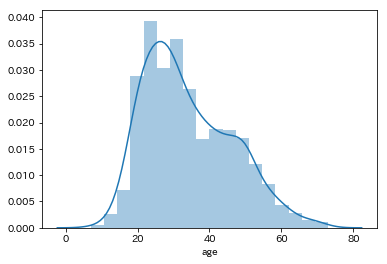

In [21]:
# 年齢
sns.distplot(user_info['age'].dropna())
plt.show()

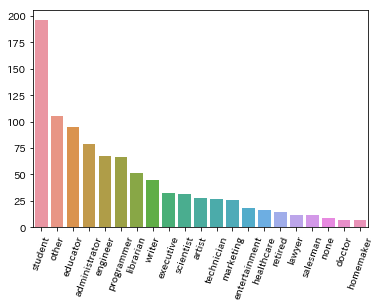

In [22]:
# 職業
occ_count = user_info['occupation'].value_counts(dropna=False)
sns.barplot(occ_count.index, occ_count.values)
plt.xticks(rotation=70)
plt.show()

#### アイテム情報

In [23]:
item_info = pd.read_csv("../input/movielens/ml-100k/u.item", sep="|", header=None, encoding="latin-1", dtype='object')
item_info.columns = ["item_id", "title", "release_date", "video_release date",
                                      "IMDb_URL", "unknown", "Action", "Adventure", "Animation", 
                                      "Childrens", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", 
                                      "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", 
                                      "Thriller", "War", "Western"]
item_info['release_date'] = pd.to_datetime(item_info['release_date'])
print(item_info.shape)
display(item_info.sample(100))

(1682, 24)


,item_id,title,release_date,video_release date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1053,1054,Mr. Wrong (1996),1996-02-16,NaN,http://us.imdb.com/M/title-exact?Mr.%20Wrong%2...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
17,18,"White Balloon, The (1995)",1995-01-01,NaN,http://us.imdb.com/M/title-exact?Badkonake%20S...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
334,335,How to Be a Player (1997),1997-01-01,NaN,http://us.imdb.com/M/title-exact?How+to+Be+a+P...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1279,1280,Gang Related (1997),1997-01-01,NaN,http://us.imdb.com/M/title-exact?Gang+Related+...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1538,1539,Being Human (1993),1993-01-01,NaN,http://us.imdb.com/M/title-exact?Being%20Human...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
918,919,"City of Lost Children, The (1995)",1995-01-01,NaN,http://us.imdb.com/Title?Cit%E9+des+enfants+pe...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
329,330,187 (1997),1997-01-01,NaN,http://us.imdb.com/M/title-exact?187+(1997),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1144,1145,Blue Chips (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?Blue%20Chips%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
615,616,Night of the Living Dead (1968),1968-01-01,NaN,http://us.imdb.com/M/title-exact?Night%20of%20...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1088,1089,Speed 2: Cruise Control (1997),1997-06-13,NaN,http://us.imdb.com/M/title-exact?Speed%202%3A%...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [24]:
##########
# 結合
##########
df_train = pd.merge(df_train, item_info, on=['item_id'], how='left')
df_test = pd.merge(df_test, item_info, on=['item_id'], how='left')

df_train.sample(100)

,user_id,item_id,rating,unix_timestamp,date,age,gender,occupation,zip_code,title,release_date,video_release date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
63490,640,338,5.0,886353852,1998-02-01 17:24:12,20,M,student,61801,Bean (1997),1997-01-01,NaN,http://us.imdb.com/M/title-exact?Bean+(1997),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
89281,930,845,3.0,879534724,1997-11-14 19:12:04,28,F,scientist,07310,That Thing You Do! (1996),1996-09-28,NaN,http://us.imdb.com/M/title-exact?That%20Thing%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
26709,291,143,3.0,875086921,1997-09-24 07:42:01,19,M,student,44106,"Sound of Music, The (1965)",1965-01-01,NaN,http://us.imdb.com/M/title-exact?Sound%20of%20...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
23316,266,14,4.0,892258004,1998-04-11 01:26:44,62,F,administrator,78756,"Postino, Il (1994)",1994-01-01,NaN,"http://us.imdb.com/M/title-exact?Postino,%20Il...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
12955,144,524,5.0,888105081,1998-02-21 23:51:21,53,M,programmer,20910,"Great Dictator, The (1940)",1940-01-01,NaN,http://us.imdb.com/M/title-exact?Great%20Dicta...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
47300,457,58,4.0,882397177,1997-12-17 22:19:37,33,F,salesman,30011,Quiz Show (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?Quiz%20Show%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
64715,650,270,4.0,891368959,1998-03-31 18:29:19,42,M,engineer,83814,Gattaca (1997),1997-01-01,NaN,http://us.imdb.com/M/title-exact?Gattaca+(1997),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
53834,527,153,5.0,879455847,1997-11-13 21:17:27,33,M,librarian,12180,"Fish Called Wanda, A (1988)",1988-01-01,NaN,http://us.imdb.com/M/title-exact?Fish%20Called...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
39995,398,1450,5.0,875717717,1997-10-01 14:55:17,40,M,other,60008,Golden Earrings (1947),1947-01-01,NaN,http://us.imdb.com/M/title-exact?Golden%20Earr...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
71930,731,64,5.0,886179040,1998-01-30 16:50:40,41,F,educator,70403,"Shawshank Redemption, The (1994)",1994-01-01,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [25]:
# リリースした年を特徴量として追加
df_train['release_year'] = df_train['release_date'].dt.year
df_test['release_year'] = df_test['release_date'].dt.year

### 使用する特徴量

In [26]:
features_base = ['user_id', 'item_id', 'age', 'gender', 'occupation', 'release_year']
genres = ['unknown','Action','Adventure','Animation','Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

features = features_base + genres

In [27]:
categorical_features = ['user_id', 'item_id','gender', 'occupation']
num_features = [col for col in features if col not in categorical_features+genres]
num_features

['age', 'release_year']

In [28]:
X_train = df_train[features]
X_test = df_test[features]

y_train = df_train['rating']
y_test = df_test['rating']

assert X_train.shape[0]==len(y_train)
assert X_test.shape[0]==len(y_test)
assert X_train.shape[1]==X_test.shape[1]

## fastFM

In [29]:
# 欠損値の確認
print('# of NaN in train: \n', X_train.isnull().sum())
print('# of NaN in test: \n', X_test.isnull().sum())

# of NaN in train: 
 user_id         0
item_id         0
age             0
gender          0
occupation      0
release_year    8
unknown         0
Action          0
Adventure       0
Animation       0
Childrens       0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
dtype: int64
# of NaN in test: 
 user_id         0
item_id         0
age             0
gender          0
occupation      0
release_year    1
unknown         0
Action          0
Adventure       0
Animation       0
Childrens       0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
dtype: int64


In [30]:
# 連続変数カラムの欠損値補完
X_train[num_features] = X_train[num_features].fillna(X_train[num_features].mean())
X_test[num_features] = X_test[num_features].fillna(X_train[num_features].mean())

# 連続変数の標準正規化
scale = StandardScaler()
X_train[num_features] = scale.fit_transform(X_train[num_features])
X_test[num_features] = scale.transform(X_test[num_features])

In [31]:
# 入力の変換  
X_train[categorical_features] = X_train[categorical_features].astype('object')
X_test[categorical_features] = X_test[categorical_features].astype('object')

dv = DictVectorizer()
X_train = dv.fit_transform(list(X_train.T.to_dict().values()))
X_test = dv.transform(list(X_test.T.to_dict().values()))

In [32]:
params = {
    'rank': 2,  # embedding次元
    'l2_reg': 0.1,
    'n_iter': 1000,
    'init_stdev': 0.1,
    'random_state': 0,
}

model = als.FMRegression(**params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('test RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

test RMSE:  0.986750977612725


## DeepCTR

####  カテゴリカル変数の処理
- ジャンルだけ，すでにワンホットエンコーディングとなっている
- ただし，一つのアイテムは一つのジャンルではなく，複数のジャンルを持ちうる（最大６ジャンル）
- そのため，ジャンル１，ジャンル２，．．．，ジャンル６というカラムを作成する(例えば，１つしかない場合は0パディングする)

In [33]:
# まず，ジャンルをラベルエンコードする辞書を作成
key2index = {}
for i, genre in enumerate(genres):
    key2index[genre] = i+1  # 0は入れない，なぜなら，０は値がないことの意味として使いたいから
key2index

{'unknown': 1,
 'Action': 2,
 'Adventure': 3,
 'Animation': 4,
 'Childrens': 5,
 'Comedy': 6,
 'Crime': 7,
 'Documentary': 8,
 'Drama': 9,
 'Fantasy': 10,
 'Film-Noir': 11,
 'Horror': 12,
 'Musical': 13,
 'Mystery': 14,
 'Romance': 15,
 'Sci-Fi': 16,
 'Thriller': 17,
 'War': 18,
 'Western': 19}

In [34]:
def make_genre_flag(df_row_array):
    """
    各行ごとに，ジャンルでフラグが立っているもののリストを返す
    """
    return [ind for ind in np.where(df_row_array=='1')[0]]

def add_genres(df):
    """
    各アイテムが持つ（エンコードした）ジャンルをリストとして，各要素に持つカラムを作成
    """
    df_genres = df[genres]
    df['genres'] = df_genres.apply(make_genre_flag, axis=1)
    df.drop(genres, axis=1, inplace=True)
    return df

df_train = add_genres(df_train)
df_test = add_genres(df_test)

df_train.sample(100)

,user_id,item_id,rating,unix_timestamp,date,age,gender,occupation,zip_code,title,release_date,video_release date,IMDb_URL,release_year,genres
63329,639,178,5.0,891240543,1998-03-30 06:49:03,42,F,librarian,12065,12 Angry Men (1957),1957-01-01,NaN,http://us.imdb.com/M/title-exact?12%20Angry%20...,1957.0,[8]
36925,374,952,2.0,883627906,1998-01-01 04:11:46,36,M,executive,78746,Blue in the Face (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Blue%20in%20t...,1995.0,[5]
30247,311,967,3.0,884364764,1998-01-09 16:52:44,32,M,technician,73071,Little Lord Fauntleroy (1936),1936-01-01,NaN,http://us.imdb.com/M/title-exact?Little%20Lord...,1936.0,[8]
36321,370,98,4.0,879434937,1997-11-13 15:28:57,52,M,writer,08534,"Silence of the Lambs, The (1991)",1991-01-01,NaN,http://us.imdb.com/M/title-exact?Silence%20of%...,1991.0,"[8, 16]"
83928,880,40,2.0,880174904,1997-11-22 05:01:44,13,M,student,83702,"To Wong Foo, Thanks for Everything! Julie Newm...",1995-01-01,NaN,http://us.imdb.com/M/title-exact?To%20Wong%20F...,1995.0,[5]
70644,714,1028,4.0,892777877,1998-04-17 01:51:17,26,M,engineer,55343,Grumpier Old Men (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Grumpier%20Ol...,1995.0,"[5, 14]"
34656,345,1007,5.0,884994119,1998-01-16 23:41:59,28,F,librarian,94143,Waiting for Guffman (1996),1997-01-31,NaN,http://us.imdb.com/M/title-exact?Waiting%20for...,1997.0,[5]
43965,429,484,5.0,882384920,1997-12-17 18:55:20,27,M,student,29205,"Maltese Falcon, The (1941)",1941-01-01,NaN,http://us.imdb.com/M/title-exact?Maltese%20Fal...,1941.0,"[10, 13]"
84059,880,310,3.0,892958036,1998-04-19 03:53:56,13,M,student,83702,"Rainmaker, The (1997)",1997-01-01,NaN,"http://us.imdb.com/M/title-exact?Rainmaker,+Th...",1997.0,[8]
39698,396,1,4.0,884646346,1998-01-12 23:05:46,57,M,engineer,94551,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,"[3, 4, 5]"


In [35]:
# 最大ジャンル保有数, max_length
genres_length_train = np.array(list(map(len, df_train['genres'])))
genres_length_test = np.array(list(map(len, df_test['genres'])))
max_len_train = max(genres_length_train)
max_len_test = max(genres_length_test)

if max_len_train > max_len_test:
    max_len = max_len_train
else:
    max_len = max_len_test
print('max length of genres of each item: ', max_len)

max length of genres of each item:  6


In [36]:
# 最大ジャンル保有数の長さの列のarrayを作成し，短ければ0パディングする

from tensorflow.python.keras.preprocessing.sequence import pad_sequences

genre_array_train = pad_sequences(list(df_train['genres']), maxlen=max_len, padding='post', )
genre_array_test = pad_sequences(list(df_test['genres']), maxlen=max_len, padding='post', )

print(genre_array_train.shape)
display(genre_array_train)

print(genre_array_test.shape)
display(genre_array_test)

(90570, 6)


array([[ 3,  4,  5,  0,  0,  0],
       [ 1,  2, 16,  0,  0,  0],
       [16,  0,  0,  0,  0,  0],
       ...,
       [ 1,  5, 18,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0],
       [ 8,  0,  0,  0,  0,  0]], dtype=int32)

(9428, 6)


array([[ 8, 14,  0,  0,  0,  0],
       [ 1, 14, 16,  0,  0,  0],
       [ 8,  0,  0,  0,  0,  0],
       ...,
       [18,  0,  0,  0,  0,  0],
       [ 1,  8,  0,  0,  0,  0],
       [ 5,  0,  0,  0,  0,  0]], dtype=int32)

In [37]:
# ジャンル１，ジャンル２，．．．，ジャンル６というカラムを作成
name_list = ['genre%d'%i for i in range(max_len)]
for i, n in enumerate(name_list):
    df_train[n] = genre_array_train[:, i]
    df_test[n] = genre_array_test[:, i]
df_train = df_train.astype({'genre%d'%i: 'object' for i in range(max_len)})
df_test = df_test.astype({'genre%d'%i: 'object' for i in range(max_len)})

df_train.drop('genres', axis=1, inplace=True)
df_test.drop('genres', axis=1, inplace=True)

df_train.sample(100)

,user_id,item_id,rating,unix_timestamp,date,age,gender,occupation,zip_code,title,release_date,video_release date,IMDb_URL,release_year,genre0,genre1,genre2,genre3,genre4,genre5
68562,689,763,4.0,876676165,1997-10-12 17:09:25,25,M,other,45439,Happy Gilmore (1996),1996-02-16,NaN,http://us.imdb.com/M/title-exact?Happy%20Gilmo...,1996.0,5,0,0,0,0,0
6399,64,238,4.0,889739025,1998-03-12 21:43:45,32,M,educator,43202,Raising Arizona (1987),1987-01-01,NaN,http://us.imdb.com/M/title-exact?Raising%20Ari...,1987.0,5,0,0,0,0,0
57446,561,92,3.0,885809897,1998-01-26 10:18:17,23,M,engineer,60005,True Romance (1993),1993-01-01,NaN,http://us.imdb.com/M/title-exact?True%20Romanc...,1993.0,1,6,14,0,0,0
72699,747,69,5.0,888640475,1998-02-28 04:34:35,19,M,other,93612,Forrest Gump (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?Forrest%20Gum...,1994.0,5,14,17,0,0,0
75166,773,769,1.0,888540390,1998-02-27 00:46:30,20,M,student,55414,Congo (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Congo%20(1995),1995.0,1,2,13,15,0,0
10836,110,1055,2.0,886988134,1998-02-09 01:35:34,19,M,student,77840,"Simple Twist of Fate, A (1994)",1994-01-01,NaN,http://us.imdb.com/M/title-exact?Simple%20Twis...,1994.0,8,0,0,0,0,0
80286,838,1115,4.0,887064476,1998-02-09 22:47:56,23,M,student,01375,Twelfth Night (1996),1996-10-25,NaN,http://us.imdb.com/M/title-exact?Twelfth%20Nig...,1996.0,5,8,14,0,0,0
19532,222,227,3.0,878184171,1997-10-30 04:02:51,29,M,programmer,27502,Star Trek VI: The Undiscovered Country (1991),1991-01-01,NaN,http://us.imdb.com/M/title-exact?Star%20Trek%2...,1991.0,1,2,15,0,0,0
9938,99,651,5.0,885679833,1998-01-24 22:10:33,20,M,student,63129,Glory (1989),1989-01-01,NaN,http://us.imdb.com/M/title-exact?Glory%20(1989),1989.0,1,8,17,0,0,0
81380,848,65,2.0,887038527,1998-02-09 15:35:27,46,M,engineer,02146,What's Eating Gilbert Grape (1993),1993-01-01,NaN,http://us.imdb.com/M/title-exact?What's%20Eati...,1993.0,5,8,0,0,0,0


### 入力

In [38]:
features_base = ['user_id', 'item_id', 'age', 'gender', 'occupation', 'release_year']
genres = copy.deepcopy(name_list)

features = features_base + genres
features

['user_id',
 'item_id',
 'age',
 'gender',
 'occupation',
 'release_year',
 'genre0',
 'genre1',
 'genre2',
 'genre3',
 'genre4',
 'genre5']

In [39]:
X_train = df_train[features]
X_test = df_test[features]

y_train = df_train['rating']
y_test = df_test['rating']

assert X_train.shape[0]==len(y_train)
assert X_test.shape[0]==len(y_test)
assert X_train.shape[1]==X_test.shape[1]

#### 各カラムの仕様を決める

In [40]:
from deepctr.inputs import DenseFeat, VarLenSparseFeat, get_varlen_feature_names

# 先ほどとは異なり，今回は連続変数のカラムもあるので，それはdense_feature_columnsとする
sparse_feature_columns = ['user_id', 'item_id', 'gender', 'occupation']
dense_feature_columns = ['age', 'release_year']

# さらに，今回はsequence_featuresも追加
# これは，上記のカラムと異なるエンベディングの仕様を
sequence_features = genres[:]

In [41]:
# カテゴリカルカラムのラベルエンコーディングと欠損値補完
for col in sparse_feature_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    
    ###############################################################################
    # テストデータで初めて現れる未知ラベルに対するエンコード（今回は，上ですでにそのようなもの削除しているので関係ない）
    ## 例えば，ここでは未知ラベルは, nanにして, 最頻値で埋めることにする
    ###############################################################################
    X_test.loc[~X_test[col].isin(le.classes_), col] = np.nan
    X_test[col] = X_test[col].fillna(X_test[col].mode()[0])
    
    X_test[col] = le.transform(X_test[col])

In [42]:
# 連続変数カラムの欠損値補完
X_train[dense_feature_columns] = X_train[dense_feature_columns].fillna(X_train[dense_feature_columns].mean())
X_test[dense_feature_columns] = X_test[dense_feature_columns].fillna(X_train[dense_feature_columns].mean())

# 連続変数の正規化
scale = StandardScaler()
X_train[dense_feature_columns] = scale.fit_transform(X_train[dense_feature_columns])
X_test[dense_feature_columns] = scale.transform(X_test[dense_feature_columns])

In [43]:
# sparse_featuresはワンホットエンコード
# dense_featuresは１つのそのままのカラム
fixlen_feature_columns = [SparseFeat(feat, X_train[feat].nunique()) for feat in sparse_feature_columns] \
                                            +[DenseFeat(feat, 1) for feat in dense_feature_columns]

# sequence_featuresは平均操作で１つにまとめる
varlen_feature_columns = [VarLenSparseFeat('genres', len(key2index) + 1, max_len, 'mean')]
varlen_feature_columns

[VarLenSparseFeat(name='genres', dimension=20, maxlen=6, combiner='mean', use_hash=False, dtype='float32', embedding_name='genres', embedding=True)]

In [44]:
# DeepなFMの場合，FM-partと，DNN-partの２つの部分に基本的に別れるため，そこの区別をする
# 全てのカラムをどちらの部分にも入力する

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

# 単にfeaturesの名前取得
fixlen_feature_names = get_fixlen_feature_names(fixlen_feature_columns)
varlen_feature_names = get_varlen_feature_names(varlen_feature_columns)

feature_names = fixlen_feature_names + varlen_feature_names
feature_names

['user_id', 'item_id', 'gender', 'occupation', 'age', 'release_year', 'genres']

In [45]:
# 入力
train_fixlen_input = [X_train[name].values for name in fixlen_feature_names]
train_varlen_input = [X_train[['genre%d'%i for i in range(max_len)]]]
train_model_input = train_fixlen_input + train_varlen_input

test_fixlen_input = [X_test[name].values for name in fixlen_feature_names]
test_varlen_input = [X_test[['genre%d'%i for i in range(max_len)]]]
test_model_input = test_fixlen_input + test_varlen_input

#### 学習と評価

In [46]:
from deepctr.models import DeepFM
from tensorflow.python.keras.callbacks import EarlyStopping

params = {
    'linear_feature_columns': linear_feature_columns, 
    'dnn_feature_columns': dnn_feature_columns, 
    'task': 'regression',  
    'embedding_size': 4, 
    'dnn_hidden_units': [64, 64], 
    'dnn_dropout': 0.1, 
    'seed': 0,
}

model = DeepFM(**params)
model.compile("adam", "mse", metrics=['mse'], )
es = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_model_input, y_train,  
                batch_size=128, epochs=20, verbose=2, validation_split=0.1, callbacks=[es])

y_pred = model.predict(test_model_input)
print('test RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))

Train on 81513 samples, validate on 9057 samples
Epoch 1/20
 - 8s - loss: 1.6168 - mean_squared_error: 1.6167 - val_loss: 1.1104 - val_mean_squared_error: 1.1102
Epoch 2/20
 - 3s - loss: 0.9479 - mean_squared_error: 0.9477 - val_loss: 1.0318 - val_mean_squared_error: 1.0316
Epoch 3/20
 - 3s - loss: 0.9155 - mean_squared_error: 0.9153 - val_loss: 1.0123 - val_mean_squared_error: 1.0120
Epoch 4/20
 - 3s - loss: 0.8957 - mean_squared_error: 0.8953 - val_loss: 0.9956 - val_mean_squared_error: 0.9952
Epoch 5/20
 - 3s - loss: 0.8763 - mean_squared_error: 0.8758 - val_loss: 1.0159 - val_mean_squared_error: 1.0154
Epoch 6/20
 - 3s - loss: 0.8564 - mean_squared_error: 0.8558 - val_loss: 1.0007 - val_mean_squared_error: 1.0001
Epoch 7/20
 - 4s - loss: 0.8389 - mean_squared_error: 0.8382 - val_loss: 1.0062 - val_mean_squared_error: 1.0055
Epoch 8/20
 - 3s - loss: 0.8286 - mean_squared_error: 0.8278 - val_loss: 0.9959 - val_mean_squared_error: 0.9951
Epoch 9/20
 - 3s - loss: 0.8205 - mean_squared_

# Tips

 ### fastFMの入力形式に変換する際に，DictVectorizerを用いたが，データ量が多いと時間がかかって遅いことがある


- LabelBinarizer(sparse_output=True)を使う
- 各カラムごとに変換して用いるもの
- なので, 必要なカラムをsparse行列に変換して, sp.sparse.hstackで, concatを行う

In [47]:
from sklearn.preprocessing import LabelBinarizer
import scipy as sp

lb = LabelBinarizer(sparse_output=True)

X_train_fm_tmp = X_train.copy()
X_test_fm_tmp = X_test.copy()

# カテゴリカルカラムだけLabelBinarizerをかませる
# 各カラムごとに変換して，concatしていく
for i, col in enumerate(categorical_features):
    if i==0:
        X_train_fm = lb.fit_transform(list(X_train_fm_tmp[col].values))
        X_test_fm = lb.transform(list(X_test_fm_tmp[col].values))
    else:
        X_train_fm_part = lb.fit_transform(list(X_train_fm_tmp[col].values))
        X_test_fm_part = lb.transform(list(X_test_fm_tmp[col].values))
        
        X_train_fm = sp.sparse.hstack([X_train_fm, X_train_fm_part])
        X_test_fm = sp.sparse.hstack([X_test_fm, X_test_fm_part])

# 数値カラムはそのまま，sparse行列にする
X_train_fm_num = sp.sparse.csr_matrix(X_train[num_features])
X_test_fm_num = sp.sparse.csr_matrix(X_test[num_features])

# カテゴリカルカラムと数値カラムを結合
X_train_fm = sp.sparse.hstack([X_train_fm_num, X_train_fm])
X_test_fm = sp.sparse.hstack([X_test_fm_num, X_test_fm])

assert X_train_fm.shape[1]==X_test_fm.shape[1]

#### pd.get_dummiesでもよい
- ただし，すぐにメモリエラーになるので注意が必要

In [48]:
X_train_fm = pd.get_dummies(X_train)
X_test_fm = pd.get_dummies(X_test)

# ワンホット化したものを，sparse行列に変換
X_train_fm = sp.sparse.csr_matrix(X_train_fm)
X_test_fm = sp.sparse.csr_matrix(X_test_fm)